In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("../..")
%matplotlib inline

In [2]:
from processor.preprocessors import data_split
from trading_env.env_cryptotrading_v1 import CryptoTradingEnv
from agent.models import DRLAgent
from config import (
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    VALID_2_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from stable_baselines3.common.logger import configure

In [3]:
processed_dts10_add_tech = pd.read_csv("../../dataset/daily-level/crypto_TI_t10_2023-04-01.csv")

In [4]:
state_interval = 5
TEST_START_DATE = pd.to_datetime(TEST_START_DATE)
TEST_START_DATE = TEST_START_DATE - pd.Timedelta(days=state_interval - 1)
TEST_START_DATE = TEST_START_DATE.strftime('%Y-%m-%d')

In [5]:
train = data_split(processed_dts10_add_tech, TRAIN_START_DATE, VALID_2_END_DATE)
valid = data_split(processed_dts10_add_tech, TEST_START_DATE, TEST_END_DATE)
print(len(train))
print(len(valid))

7290
940


In [6]:
crypto_tic_dim = len(train.tic.unique())
# state_space_dim = 1 + 2*crypto_tic_dim + len(INDICATORS)*crypto_tic_dim
state_space_dim = 1 + (state_interval * 5 + 1) * crypto_tic_dim
print(f"Stock Dimension: {crypto_tic_dim}, State Space: {state_space_dim}")

Stock Dimension: 10, State Space: 261


## Agents

### PPO

In [7]:
buy_cost_list = sell_cost_list = [0.001] * crypto_tic_dim
num_stock_shares = [0] * crypto_tic_dim

env_kwargs_train = {
    "cash": 100000,
    "action_scaling": 1/10,
    "num_crypto_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space_dim": state_space_dim,
    "crypto_dim": crypto_tic_dim,
    "action_space_dim": crypto_tic_dim,
    # "tech_indicator_list": INDICATORS,
    "print_verbosity": 50,
    "eval_time_interval": 30,
    "is_debug": True,
    "risk_control": True,
    "model_name": "ppo_daily_level_new_reward_stack_5",
    "data_granularity": 1,
    "state_interval": state_interval
}
env_kwargs_test = env_kwargs_train.copy()
env_kwargs_test["is_debug"] = False

In [8]:
e_train_gym = CryptoTradingEnv(df = train, **env_kwargs_train)
e_valid_gym = CryptoTradingEnv(df = valid, **env_kwargs_test)

In [9]:
agent = DRLAgent(env = e_train_gym)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.001,
    "batch_size": 256
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS, seed=42)
# set up logger
tmp_path = RESULTS_DIR + '/ppo_daily_level_new_reward_stack_5'
new_logger_ppo = configure(tmp_path, ["csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 256}
Using cuda device


In [10]:
final = []
iterations = 30
max_account_value = 0

for i in range(iterations):
    # train model
    trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=100000)
    df_account_value_ppo, df_actionppo, df_valid_actionppo, df_stateppo = DRLAgent.DRL_prediction(model=trained_ppo, environment=e_valid_gym)
    res = df_account_value_ppo["portfolio_value"][len(df_account_value_ppo)-1]
    final.append(df_account_value_ppo["portfolio_value"])
    df_account_value_ppo.to_csv(f"../../plot/dataset/ppo_daily_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_new_reward.csv")
    trained_ppo.save(f"../../model_saves/ppo_daily_stack_frame/test/stack_5_round_{i + 1}_res_{res:.0f}_default_ppo_act_0.1_seed_42_new_reward")


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 50
begin_portfolio_value:	 99950.89
end_portfolio_value:	 770559.69
total_profits:		 670608.81
total_buy_cost:		 120371.21
total_sell_cost:	 120624.11
total_buy_trades:	 2355
total_sell_trades:	 2335

episode:		 100
begin_portfolio_value:	 99976.44
end_portfolio_value:	 385019.98
total_profits:		 285043.54
total_buy_cost:		 100664.98
total_sell_cost:	 101044.71
total_buy_trades:	 2296
total_sell_trades:	 2304

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 150
begin_portfolio_value:	 99962.45
end_portfolio_value:	 239781.50
total_profits:		 139819.06
total_buy_cost:		 79751.41
total_sell_cost:	 79915.64
total_buy_trades:	 2353
total_sell_trades:	 2235

episode:		 200
begin_portfolio_value:	 99964.58
end_portfolio_value:	 521847.13
total_profits:		 421882.55
total_buy_cost:		 121064.46
total_sell_cost:	 121206.73
total_buy_trades:	 2354
total_sell_trades:	 2270

episode:		 250
begin_portfolio_value:	 99956.14
end_portfolio_value:	 220445.88
total_profits:		 120489.74
total_buy_cost:		 55996.85
total_sell_cost:	 56087.75
total_buy_trades:	 2284
total_sell_trades:	 2189

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 300
begin_portfolio_value:	 99966.35
end_portfolio_value:	 327685.17
total_profits:		 227718.82
total_buy_cost:		 66874.11
total_sell_cost:	 67104.78
total_buy_trades:	 2329
total_sell_trades:	 2219

episode:		 350
begin_portfolio_value:	 99957.06
end_portfolio_value:	 260469.05
total_profits:		 160512.00
total_buy_cost:		 70012.61
total_sell_cost:	 70215.72
total_buy_trades:	 2230
total_sell_trades:	 2208

episode:		 400
begin_portfolio_value:	 99960.04
end_portfolio_value:	 444417.30
total_profits:		 344457.26
total_buy_cost:		 121545.76
total_sell_cost:	 121688.99
total_buy_trades:	 2243
total_sell_trades:	 2170

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 450
begin_portfolio_value:	 99948.48
end_portfolio_value:	 390360.43
total_profits:		 290411.95
total_buy_cost:		 86333.67
total_sell_cost:	 86797.16
total_buy_trades:	 2250
total_sell_trades:	 2182

episode:		 500
begin_portfolio_value:	 99945.45
end_portfolio_value:	 137005.89
total_profits:		 37060.44
total_buy_cost:		 49146.72
total_sell_cost:	 49241.84
total_buy_trades:	 2272
total_sell_trades:	 2200

episode:		 550
begin_portfolio_value:	 99962.51
end_portfolio_value:	 511642.03
total_profits:		 411679.52
total_buy_cost:		 94178.61
total_sell_cost:	 94623.06
total_buy_trades:	 2149
total_sell_trades:	 2048

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 600
begin_portfolio_value:	 99950.05
end_portfolio_value:	 235798.85
total_profits:		 135848.80
total_buy_cost:		 69869.29
total_sell_cost:	 70074.35
total_buy_trades:	 2185
total_sell_trades:	 2077

episode:		 650
begin_portfolio_value:	 99950.20
end_portfolio_value:	 474220.35
total_profits:		 374270.14
total_buy_cost:		 96885.28
total_sell_cost:	 96979.14
total_buy_trades:	 2197
total_sell_trades:	 2083

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 700
begin_portfolio_value:	 99936.21
end_portfolio_value:	 246025.35
total_profits:		 146089.15
total_buy_cost:		 55967.95
total_sell_cost:	 55979.90
total_buy_trades:	 2180
total_sell_trades:	 2070

episode:		 750
begin_portfolio_value:	 99932.61
end_portfolio_value:	 246964.20
total_profits:		 147031.59
total_buy_cost:		 74021.85
total_sell_cost:	 74069.94
total_buy_trades:	 2173
total_sell_trades:	 2085

episode:		 800
begin_portfolio_value:	 99952.80
end_portfolio_value:	 230701.10
total_profits:		 130748.30
total_buy_cost:		 92050.05
total_sell_cost:	 92134.23
total_buy_trades:	 2195
total_sell_trades:	 2106

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 850
begin_portfolio_value:	 99950.05
end_portfolio_value:	 126159.31
total_profits:		 26209.26
total_buy_cost:		 54551.07
total_sell_cost:	 54618.96
total_buy_trades:	 2083
total_sell_trades:	 1980

episode:		 900
begin_portfolio_value:	 99960.04
end_portfolio_value:	 575536.63
total_profits:		 475576.59
total_buy_cost:		 136254.64
total_sell_cost:	 136559.20
total_buy_trades:	 2157
total_sell_trades:	 2054

episode:		 950
begin_portfolio_value:	 99959.48
end_portfolio_value:	 332814.26
total_profits:		 232854.77
total_buy_cost:		 115117.54
total_sell_cost:	 115247.91
total_buy_trades:	 2085
total_sell_trades:	 1954

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1000
begin_portfolio_value:	 99940.06
end_portfolio_value:	 801523.34
total_profits:		 701583.28
total_buy_cost:		 190110.77
total_sell_cost:	 190565.16
total_buy_trades:	 2142
total_sell_trades:	 2097

episode:		 1050
begin_portfolio_value:	 99960.04
end_portfolio_value:	 342020.52
total_profits:		 242060.48
total_buy_cost:		 86710.73
total_sell_cost:	 86941.88
total_buy_trades:	 2144
total_sell_trades:	 2032

episode:		 1100
begin_portfolio_value:	 99990.01
end_portfolio_value:	 881405.24
total_profits:		 781415.23
total_buy_cost:		 153683.72
total_sell_cost:	 154249.03
total_buy_trades:	 2150
total_sell_trades:	 2077

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1150
begin_portfolio_value:	 99944.20
end_portfolio_value:	 237270.30
total_profits:		 137326.10
total_buy_cost:		 68524.84
total_sell_cost:	 68637.64
total_buy_trades:	 2128
total_sell_trades:	 2021

episode:		 1200
begin_portfolio_value:	 99970.03
end_portfolio_value:	 397636.27
total_profits:		 297666.24
total_buy_cost:		 117048.68
total_sell_cost:	 117182.92
total_buy_trades:	 2144
total_sell_trades:	 2023

episode:		 1250
begin_portfolio_value:	 99960.04
end_portfolio_value:	 450537.76
total_profits:		 350577.72
total_buy_cost:		 145307.89
total_sell_cost:	 145498.69
total_buy_trades:	 2126
total_sell_trades:	 1969

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1300
begin_portfolio_value:	 99940.06
end_portfolio_value:	 584408.99
total_profits:		 484468.93
total_buy_cost:		 209196.66
total_sell_cost:	 210100.37
total_buy_trades:	 2109
total_sell_trades:	 1981

episode:		 1350
begin_portfolio_value:	 99960.04
end_portfolio_value:	 151307.98
total_profits:		 51347.94
total_buy_cost:		 43910.72
total_sell_cost:	 43898.53
total_buy_trades:	 2118
total_sell_trades:	 1992

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1400
begin_portfolio_value:	 99951.62
end_portfolio_value:	 453207.90
total_profits:		 353256.28
total_buy_cost:		 108185.56
total_sell_cost:	 108302.05
total_buy_trades:	 2077
total_sell_trades:	 1924

episode:		 1450
begin_portfolio_value:	 99928.43
end_portfolio_value:	 450209.44
total_profits:		 350281.01
total_buy_cost:		 155168.94
total_sell_cost:	 155379.49
total_buy_trades:	 2122
total_sell_trades:	 2008

episode:		 1500
begin_portfolio_value:	 99960.04
end_portfolio_value:	 263822.49
total_profits:		 163862.45
total_buy_cost:		 77494.59
total_sell_cost:	 77549.64
total_buy_trades:	 2146
total_sell_trades:	 2054

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1550
begin_portfolio_value:	 99932.25
end_portfolio_value:	 761486.48
total_profits:		 661554.22
total_buy_cost:		 145820.67
total_sell_cost:	 146367.50
total_buy_trades:	 2226
total_sell_trades:	 2140

episode:		 1600
begin_portfolio_value:	 99980.02
end_portfolio_value:	 179870.02
total_profits:		 79890.00
total_buy_cost:		 70619.34
total_sell_cost:	 70726.87
total_buy_trades:	 2180
total_sell_trades:	 2056

episode:		 1650
begin_portfolio_value:	 99980.02
end_portfolio_value:	 606983.57
total_profits:		 507003.55
total_buy_cost:		 189047.48
total_sell_cost:	 189325.85
total_buy_trades:	 2152
total_sell_trades:	 2077

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1700
begin_portfolio_value:	 99940.06
end_portfolio_value:	 201641.95
total_profits:		 101701.89
total_buy_cost:		 67375.38
total_sell_cost:	 67410.16
total_buy_trades:	 2183
total_sell_trades:	 2086

episode:		 1750
begin_portfolio_value:	 99937.29
end_portfolio_value:	 334112.35
total_profits:		 234175.07
total_buy_cost:		 107423.54
total_sell_cost:	 107538.50
total_buy_trades:	 2229
total_sell_trades:	 2102

episode:		 1800
begin_portfolio_value:	 99950.05
end_portfolio_value:	 298546.26
total_profits:		 198596.21
total_buy_cost:		 102421.61
total_sell_cost:	 102606.65
total_buy_trades:	 2240
total_sell_trades:	 2075

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1850
begin_portfolio_value:	 99952.43
end_portfolio_value:	 334119.86
total_profits:		 234167.43
total_buy_cost:		 116638.98
total_sell_cost:	 116906.25
total_buy_trades:	 2129
total_sell_trades:	 2037

episode:		 1900
begin_portfolio_value:	 99950.05
end_portfolio_value:	 267345.80
total_profits:		 167395.75
total_buy_cost:		 69403.39
total_sell_cost:	 69629.62
total_buy_trades:	 2115
total_sell_trades:	 2049

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 1950
begin_portfolio_value:	 99950.05
end_portfolio_value:	 208847.22
total_profits:		 108897.17
total_buy_cost:		 67678.23
total_sell_cost:	 67922.68
total_buy_trades:	 2101
total_sell_trades:	 2064

episode:		 2000
begin_portfolio_value:	 99978.07
end_portfolio_value:	 449983.96
total_profits:		 350005.88
total_buy_cost:		 134069.08
total_sell_cost:	 134462.72
total_buy_trades:	 2190
total_sell_trades:	 2148

episode:		 2050
begin_portfolio_value:	 99950.05
end_portfolio_value:	 396071.01
total_profits:		 296120.96
total_buy_cost:		 144071.52
total_sell_cost:	 144537.46
total_buy_trades:	 2158
total_sell_trades:	 2142

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2100
begin_portfolio_value:	 99960.04
end_portfolio_value:	 700512.80
total_profits:		 600552.76
total_buy_cost:		 206162.28
total_sell_cost:	 206895.82
total_buy_trades:	 2135
total_sell_trades:	 2079

episode:		 2150
begin_portfolio_value:	 99972.21
end_portfolio_value:	 679032.73
total_profits:		 579060.52
total_buy_cost:		 210774.62
total_sell_cost:	 211504.48
total_buy_trades:	 2187
total_sell_trades:	 2149

episode:		 2200
begin_portfolio_value:	 99939.76
end_portfolio_value:	 326200.54
total_profits:		 226260.79
total_buy_cost:		 122645.45
total_sell_cost:	 122954.23
total_buy_trades:	 2167
total_sell_trades:	 2132

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2250
begin_portfolio_value:	 99920.08
end_portfolio_value:	 258652.34
total_profits:		 158732.26
total_buy_cost:		 89811.37
total_sell_cost:	 89891.07
total_buy_trades:	 2088
total_sell_trades:	 2048

episode:		 2300
begin_portfolio_value:	 99938.55
end_portfolio_value:	 401141.29
total_profits:		 301202.74
total_buy_cost:		 131194.82
total_sell_cost:	 131678.67
total_buy_trades:	 2162
total_sell_trades:	 2090

episode:		 2350
begin_portfolio_value:	 99930.07
end_portfolio_value:	 277579.38
total_profits:		 177649.31
total_buy_cost:		 134514.86
total_sell_cost:	 134906.39
total_buy_trades:	 2198
total_sell_trades:	 2155

episode:		 50
begin_portfolio_value:	 99984.71
end_portfolio_value:	 109461.61
total_profits:		 9476.90
total_buy_cost:		 1151.93
total_sell_cost:	 1152.76
total_buy_trades:	 124
total_sell_trades:	 107

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2400
begin_portfolio_value:	 99970.03
end_portfolio_value:	 225764.11
total_profits:		 125794.08
total_buy_cost:		 68310.25
total_sell_cost:	 68459.96
total_buy_trades:	 2206
total_sell_trades:	 2115

episode:		 2450
begin_portfolio_value:	 99960.04
end_portfolio_value:	 255272.40
total_profits:		 155312.36
total_buy_cost:		 73491.63
total_sell_cost:	 73676.64
total_buy_trades:	 2234
total_sell_trades:	 2164

episode:		 2500
begin_portfolio_value:	 99932.07
end_portfolio_value:	 237382.29
total_profits:		 137450.22
total_buy_cost:		 85663.14
total_sell_cost:	 85972.16
total_buy_trades:	 2163
total_sell_trades:	 2093

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2550
begin_portfolio_value:	 99935.47
end_portfolio_value:	 447898.98
total_profits:		 347963.51
total_buy_cost:		 121058.59
total_sell_cost:	 121649.19
total_buy_trades:	 2180
total_sell_trades:	 2120

episode:		 2600
begin_portfolio_value:	 99943.33
end_portfolio_value:	 217806.19
total_profits:		 117862.85
total_buy_cost:		 69187.40
total_sell_cost:	 69225.81
total_buy_trades:	 2174
total_sell_trades:	 2072

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2650
begin_portfolio_value:	 99966.02
end_portfolio_value:	 277128.70
total_profits:		 177162.67
total_buy_cost:		 106819.35
total_sell_cost:	 106933.10
total_buy_trades:	 2114
total_sell_trades:	 2026

episode:		 2700
begin_portfolio_value:	 99920.08
end_portfolio_value:	 450222.52
total_profits:		 350302.44
total_buy_cost:		 96211.21
total_sell_cost:	 96303.72
total_buy_trades:	 2207
total_sell_trades:	 2130

episode:		 2750
begin_portfolio_value:	 99970.03
end_portfolio_value:	 162677.06
total_profits:		 62707.03
total_buy_cost:		 79525.23
total_sell_cost:	 79682.08
total_buy_trades:	 2229
total_sell_trades:	 2132

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2800
begin_portfolio_value:	 99950.05
end_portfolio_value:	 358700.11
total_profits:		 258750.06
total_buy_cost:		 115909.07
total_sell_cost:	 116292.44
total_buy_trades:	 2127
total_sell_trades:	 2012

episode:		 2850
begin_portfolio_value:	 99970.03
end_portfolio_value:	 134110.57
total_profits:		 34140.54
total_buy_cost:		 42139.15
total_sell_cost:	 42190.57
total_buy_trades:	 2209
total_sell_trades:	 2171

episode:		 2900
begin_portfolio_value:	 99970.03
end_portfolio_value:	 197526.03
total_profits:		 97556.00
total_buy_cost:		 81744.98
total_sell_cost:	 81946.98
total_buy_trades:	 2252
total_sell_trades:	 2200

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 2950
begin_portfolio_value:	 99960.04
end_portfolio_value:	 229971.86
total_profits:		 130011.82
total_buy_cost:		 124100.30
total_sell_cost:	 124340.79
total_buy_trades:	 2162
total_sell_trades:	 2080

episode:		 3000
begin_portfolio_value:	 99960.04
end_portfolio_value:	 159733.62
total_profits:		 59773.58
total_buy_cost:		 61608.52
total_sell_cost:	 61727.74
total_buy_trades:	 2190
total_sell_trades:	 2090

episode:		 3050
begin_portfolio_value:	 99960.04
end_portfolio_value:	 102925.96
total_profits:		 2965.92
total_buy_cost:		 66793.09
total_sell_cost:	 66878.25
total_buy_trades:	 2211
total_sell_trades:	 2090

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3100
begin_portfolio_value:	 99960.04
end_portfolio_value:	 290823.45
total_profits:		 190863.41
total_buy_cost:		 109004.35
total_sell_cost:	 109122.48
total_buy_trades:	 2303
total_sell_trades:	 2188

episode:		 3150
begin_portfolio_value:	 99940.06
end_portfolio_value:	 193862.87
total_profits:		 93922.81
total_buy_cost:		 57932.73
total_sell_cost:	 58084.49
total_buy_trades:	 2249
total_sell_trades:	 2176

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3200
begin_portfolio_value:	 99950.05
end_portfolio_value:	 162237.53
total_profits:		 62287.48
total_buy_cost:		 79751.41
total_sell_cost:	 79810.97
total_buy_trades:	 2164
total_sell_trades:	 2043

episode:		 3250
begin_portfolio_value:	 99970.03
end_portfolio_value:	 776167.01
total_profits:		 676196.98
total_buy_cost:		 301279.71
total_sell_cost:	 301782.77
total_buy_trades:	 2249
total_sell_trades:	 2173

episode:		 3300
begin_portfolio_value:	 99950.05
end_portfolio_value:	 222987.93
total_profits:		 123037.88
total_buy_cost:		 72665.80
total_sell_cost:	 72822.84
total_buy_trades:	 2209
total_sell_trades:	 2122

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3350
begin_portfolio_value:	 99980.02
end_portfolio_value:	 397454.41
total_profits:		 297474.39
total_buy_cost:		 123592.00
total_sell_cost:	 123898.57
total_buy_trades:	 2214
total_sell_trades:	 2087

episode:		 3400
begin_portfolio_value:	 99960.04
end_portfolio_value:	 319429.37
total_profits:		 219469.33
total_buy_cost:		 132872.98
total_sell_cost:	 133198.85
total_buy_trades:	 2256
total_sell_trades:	 2152

episode:		 3450
begin_portfolio_value:	 99940.06
end_portfolio_value:	 332661.97
total_profits:		 232721.91
total_buy_cost:		 106098.20
total_sell_cost:	 106410.39
total_buy_trades:	 2265
total_sell_trades:	 2202

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3500
begin_portfolio_value:	 99940.06
end_portfolio_value:	 403241.32
total_profits:		 303301.26
total_buy_cost:		 129112.33
total_sell_cost:	 129270.71
total_buy_trades:	 2176
total_sell_trades:	 2082

episode:		 3550
begin_portfolio_value:	 99950.05
end_portfolio_value:	 201192.72
total_profits:		 101242.67
total_buy_cost:		 89769.44
total_sell_cost:	 89969.94
total_buy_trades:	 2248
total_sell_trades:	 2120

episode:		 3600
begin_portfolio_value:	 99950.05
end_portfolio_value:	 228707.81
total_profits:		 128757.76
total_buy_cost:		 65800.35
total_sell_cost:	 65831.99
total_buy_trades:	 2202
total_sell_trades:	 2100

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3650
begin_portfolio_value:	 99970.03
end_portfolio_value:	 253271.84
total_profits:		 153301.81
total_buy_cost:		 94790.55
total_sell_cost:	 95032.39
total_buy_trades:	 2182
total_sell_trades:	 2107

episode:		 3700
begin_portfolio_value:	 99950.05
end_portfolio_value:	 201186.96
total_profits:		 101236.91
total_buy_cost:		 90940.09
total_sell_cost:	 91183.20
total_buy_trades:	 2260
total_sell_trades:	 2132

episode:		 3750
begin_portfolio_value:	 99930.07
end_portfolio_value:	 270501.84
total_profits:		 170571.77
total_buy_cost:		 99914.02
total_sell_cost:	 100013.94
total_buy_trades:	 2279
total_sell_trades:	 2119

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3800
begin_portfolio_value:	 99970.03
end_portfolio_value:	 157481.96
total_profits:		 57511.93
total_buy_cost:		 65940.72
total_sell_cost:	 66051.49
total_buy_trades:	 2281
total_sell_trades:	 2185

episode:		 3850
begin_portfolio_value:	 99940.06
end_portfolio_value:	 485727.69
total_profits:		 385787.63
total_buy_cost:		 128145.25
total_sell_cost:	 128301.70
total_buy_trades:	 2256
total_sell_trades:	 2142

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 3900
begin_portfolio_value:	 99940.06
end_portfolio_value:	 136084.29
total_profits:		 36144.23
total_buy_cost:		 71426.85
total_sell_cost:	 71520.40
total_buy_trades:	 2226
total_sell_trades:	 2132

episode:		 3950
begin_portfolio_value:	 99920.08
end_portfolio_value:	 113769.21
total_profits:		 13849.13
total_buy_cost:		 52872.63
total_sell_cost:	 52992.26
total_buy_trades:	 2216
total_sell_trades:	 2140

episode:		 4000
begin_portfolio_value:	 99970.03
end_portfolio_value:	 256966.16
total_profits:		 156996.13
total_buy_cost:		 94452.43
total_sell_cost:	 94798.65
total_buy_trades:	 2241
total_sell_trades:	 2159

hit end!


  0%|          | 0/100000 [00:00<?, ?it/s]

episode:		 4050
begin_portfolio_value:	 99960.04
end_portfolio_value:	 444968.00
total_profits:		 345007.96
total_buy_cost:		 117992.90
total_sell_cost:	 118351.84
total_buy_trades:	 2193
total_sell_trades:	 2055

episode:		 4100
begin_portfolio_value:	 99970.03
end_portfolio_value:	 519146.94
total_profits:		 419176.91
total_buy_cost:		 181502.42
total_sell_cost:	 181921.70
total_buy_trades:	 2166
total_sell_trades:	 2044

episode:		 4150
begin_portfolio_value:	 99940.06
end_portfolio_value:	 117165.64
total_profits:		 17225.58
total_buy_cost:		 61773.03
total_sell_cost:	 61796.60
total_buy_trades:	 2249
total_sell_trades:	 2151

hit end!


# Backtesting results

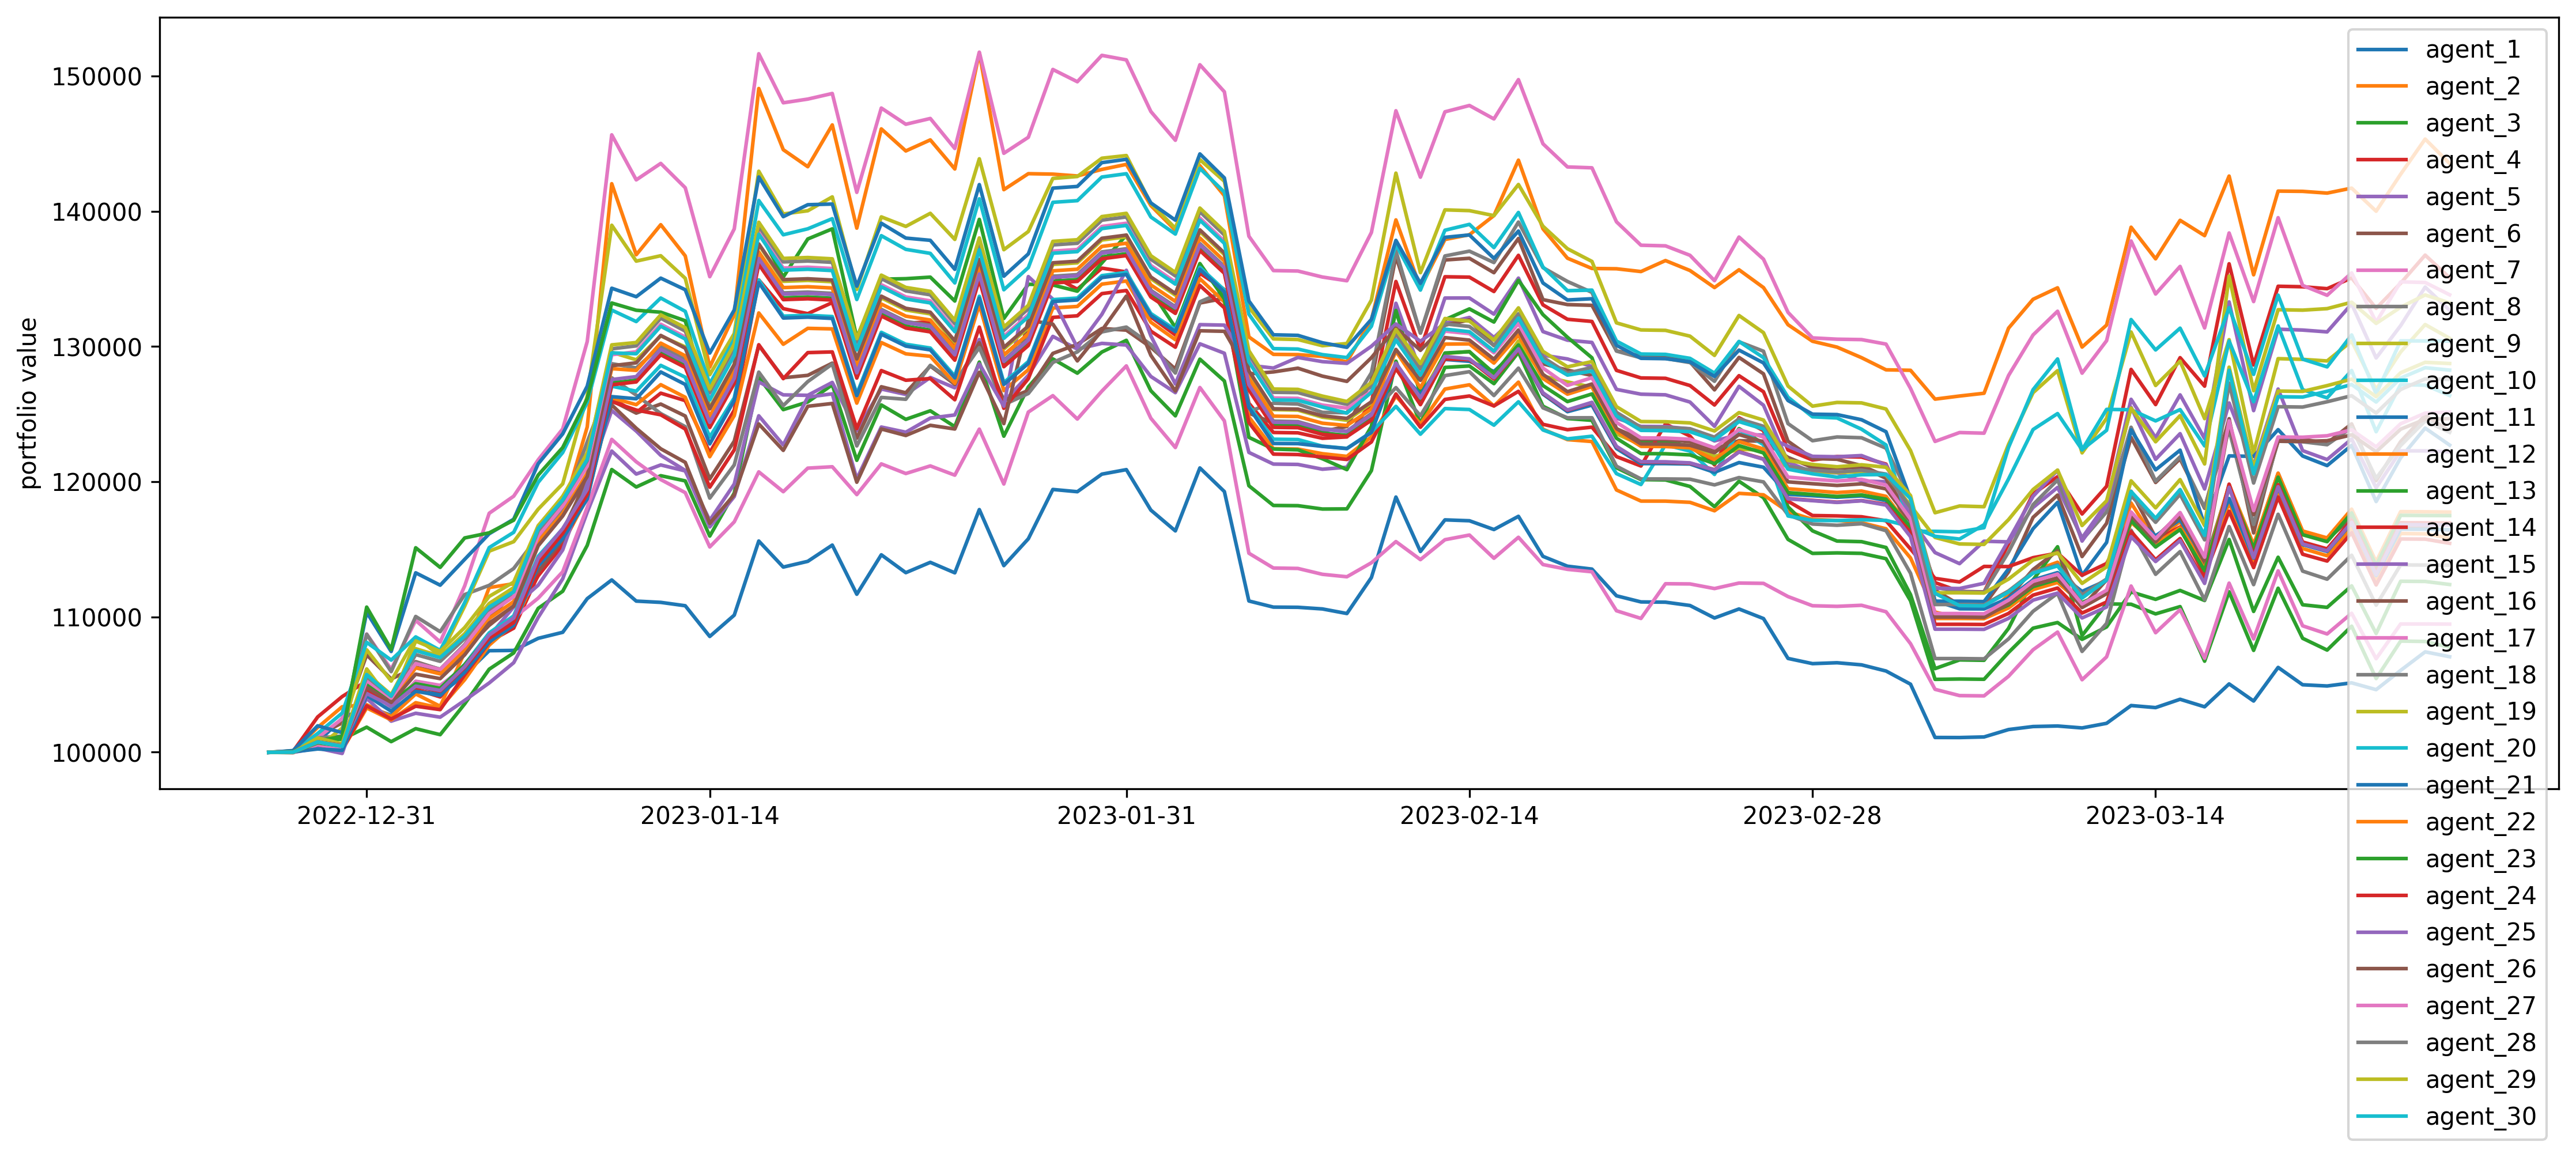

In [11]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.dpi"] = 300
plt.figure()

x = df_account_value_ppo["timestamp"]
x = pd.to_datetime(x)
s = 1
for i in final:
    plt.plot(x,i,label=f'agent_{s}')
    s+=1
plt.ylabel("portfolio value")
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig("../../plot/test_plot/ppo_daily_stack_frame/stack_5_test_default_ppo_act_0.1_seed_42_new_reward.png", dpi=300)
plt.show()

In [12]:
df = pd.DataFrame(data = x)
s = 1
for i in final:
    df[f"round_{s}"] = i
    s += 1
df.to_csv("stack_5_test_default_ppo_act_0.1_seed_42_new_reward.csv")